# Credit Risk Modelling: Probability of Default Prediction

Used logistic regression to predict probability of borrower default (PD) using real-world loan data from Lending Club. Includes variable selection, data preparation, and evaluation tools such as AUC, KS statistic, PSI, and calibration.

**Programming language:** Python.

**Data source:** Lending Club loan data (via Kaggle) — https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv

## 1. Data Preprocessing

A sample of the full dataset was used, consisting of 173,412 loans, each with 145 features.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
import matplotlib.pyplot as plt

df = pd.read_csv('loan_sample.csv', low_memory=False)

### Create binary target

Loan statuses "Charged Off" or "Default" were defined as **default** and "Fully Paid" as **non-default**. Other statuses were excluded. 

Defaulted loans were encoded as 1, non-defaulted as 0.

After filtering statuses, 100,000 loans remained (the sample was preprocessed to include this number of default and non-defaults).

In [2]:
# Filter statuses
target_statuses = ['Fully Paid', 'Charged Off', 'Default']
df_filtered = df[df['loan_status'].isin(target_statuses)].copy()

In [3]:
# Encode target
df_filtered['default'] = df_filtered['loan_status'].isin(['Charged Off', 'Default']).astype(int)

### Class distribution

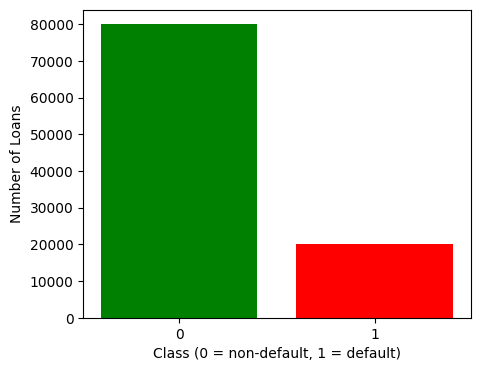

In [4]:
counts = df_filtered['default'].value_counts()
plt.figure(figsize=(5, 4))
plt.bar(counts.index.astype(str), counts.values, color=['green','red'])
plt.ylabel('Number of Loans')
plt.xlabel('Class (0 = non-default, 1 = default)')
plt.show() 

**Figure 1:** This class imbalance will make the logistic regression model more biased toward predicting probabilities near 0, since class 0 (non-defaults) represents 0. Therefore, if it is more important to correctly classify actual defaults than it is to misclassify non-defaults as default, a classification threshold smaller than 0.5 would be needed, even if that means a decrease in overall accuracy.

### Variable selection

To prevent data leakage, only variables that were certainly available at the time of loan origination were included. Since most variables were uncertain in this respect, we ended up using only five of the 144 variables (in a real-world setting more variables would be used, which most certainly would improve performance). The included variables were the following: (descriptions taken from LCDataDictionary.xlsx)

- **annual_inc**         - The self-reported annual income provided by the borrower during registration

- **application_type**   - Indicates whether the loan is an individual application or a joint application with two co-borrowers

- **dti**                - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

- **home_ownership**     - The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

- **purpose**            - A category provided by the borrower for the loan request

Example of variables with uncertain time measurements:

- **delinq_2yrs**   - The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.  
    *(may have been updated after loan origination)*

- **loan_amnt**    - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value  
  *(may have been updated after loan origination)*

Extra variables:

- **loan_status** - Current status of the loan      
    *(target variable)*
- **issue_d** - The month which the loan was funded     
    *(used only for time-based splitting)*    

In [5]:
selected_vars = [
    'annual_inc',
    'application_type',
    'dti',
    'home_ownership',
    'purpose',
    'default',  # target
    'issue_d',  # for time-based splitting
]
df_model = df_filtered[selected_vars].copy()

### Description of numeric variables

In [6]:
df_model.describe()

annual_inc           dti        default
count  1.000000e+05  99977.000000  100000.000000
mean   7.598839e+04     18.270974       0.200740
std    6.724343e+04     10.356567       0.400556
min    0.000000e+00      0.000000       0.000000
25%    4.550000e+04     11.840000       0.000000
50%    6.500000e+04     17.610000       0.000000
75%    9.000000e+04     24.060000       0.000000
max    8.900060e+06    999.000000       1.000000

**Note:** Maximum dti is 999. These unusually high values occurred for borrowers with low reported income (mean = 430 vs. overall mean = 75,989) and were therefore retained.


### Missing values

The only variable with missing values was dti, with 23 (0.02%) missing entries.

In [7]:
missing_counts = df_model.isna().sum().sort_values(ascending=False)
missing_vars = missing_counts[missing_counts > 0]

total_rows = len(df_model)

if len(missing_vars) > 0:
    print("Variables with missing values:")
    for col, count in missing_vars.items():
        percentage = (count / total_rows) * 100
        print(f"{col}: {count} ({percentage:.2f}%)")
else:
    print("No missing values found")

Variables with missing values:
dti: 23 (0.02%)


As the reason for the missing values for dti was unknown, they were replaced with the median of dti, in an effort to keep them neutral/unbiased.

In [8]:
numeric_cols = df_model.select_dtypes(include=['number']).columns
df_model[numeric_cols] = df_model[numeric_cols].fillna(df_model[numeric_cols].median())

### One-hot encoding

The categorical features (purpose, home_ownership, and application_type) were one-hot encoded.

In [9]:
categorical_cols = ['purpose', 'home_ownership', 'application_type']
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

### Time-based train/test split
To prevent data leakage and mimic a real-world scenario, the data was sorted by issue date (issue_d) and split into training (first 80%) and testing (last 20%) sets.

In [10]:
# Time-based Train/test split
df_sorted = df_model.sort_values('issue_d')

split_point = int(0.8 * len(df_sorted))

X_train = df_sorted.iloc[:split_point].drop(['default', 'issue_d'], axis=1)
y_train = df_sorted.iloc[:split_point]['default']
X_test = df_sorted.iloc[split_point:].drop(['default', 'issue_d'], axis=1)
y_test = df_sorted.iloc[split_point:]['default']

### Feature scaling

To make the coefficients in logistic regression easier to compare, the features were scaled to have mean 0 and standard deviation 1.

In [11]:
# Scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## 2. Model Training

The logistic regression model estimates the probability of default for each observation as

$$
p(\mathbf{x_1, \dots, x_m}) = \frac{1}{1 + \exp\big(-(\beta_0 + \beta_1 x_1 + \dots + \beta_m x_m)\big)},
$$

where $x_1, \dots, x_m$ are the input features, and $\beta_0, \dots, \beta_m$ are the coefficients estimated from the training data.

The formula above can also be written as

$$
\log\left(\frac{p(\bf{x})}{1 - p(\bf{x})}\right) = \beta_0 + \beta_1 x_1 + \dots + \beta_m x_m,
$$

which shows that inputs $x_i$ that correspond to positive coefficients $\beta_i$ are positively correlated with the probability $p(\bf{x})$.

The model was trained using scikit-learn’s LogisticRegression class (with its default L2 regularization).

In [12]:
# Train model and make predictions
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

## 3. Result Metrics

### Recall at threshold = 0.5

At a classification threshold of 0.5, the model correctly classified 100% of non-defaulters but 0% of defaulters. One reason for this difference is the imbalanced class proportions. Since there are 80% non-defaults, the model is biased toward predicting probabilities near 0, since 0 represents non-defaulters. As a result, the threshold of 0.5 is rarely exceeded, leading to poor recall for defaulters and perfect recall for non-defaulters.

One way to achieve a more balanced recall is to lower the classification threshold. For example, at a threshold of 0.2, the recall for defaulters is 0.58 and 0.56 for non-defaulters.

### Threshold independent metrics


#### AUC and Gini Coefficient

The model achieves an AUC of 0.605, indicating performance better than random.

(Gini = 2 × AUC − 1 = 0.209)

In [13]:
# AUC and Gini
auc = roc_auc_score(y_test, y_pred_proba)
gini = 2 * auc - 1

#### ROC

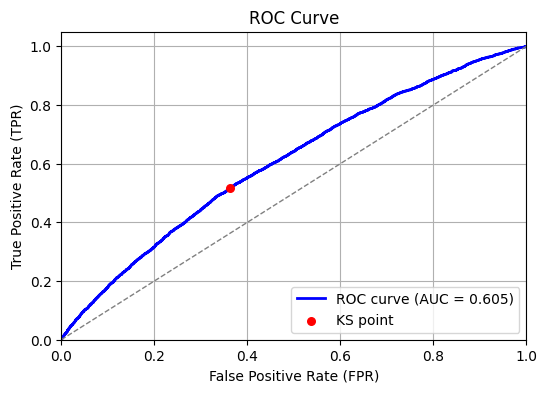

In [14]:
# ROC plot
plt.figure(figsize=(6,4))
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f})')

# plot KS point
ks_index = (tpr - fpr).argmax()
plt.scatter(fpr[ks_index], tpr[ks_index], color='red', s=30, label='KS point', zorder=5)

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Figure 2:** ROC curve showing the trade-off between TPR and FPR, with the KS point highlighted.

#### KS Statistic (Kolmogorov-Smirnov)

The model’s KS statistic is 0.156, also indicating performance better than random.

In [15]:
# KS point
ks = max(tpr - fpr)

### Stability/Monitoring Metrics

#### PSI (Population Stability Index)

The Population Stability Index (PSI), which measures population drift, is 0.002 (10 bins; comparing predicted probabilities for training and test set). This indicates that the distributions of predicted probabilities for the training and test sets are very similar, which is confirmed by the plot below.

In [16]:
# PSI code details
# Predicted probabilities for the training set
y_pred_proba_train = model.predict_proba(X_train_scaled)[:, 1]

n_bins = 10
bin_edges = np.linspace(0, 1, n_bins + 1)

df_PSI_test = pd.DataFrame({'y_pred_proba': y_pred_proba})

df_PSI_test['bin'] = pd.cut(df_PSI_test['y_pred_proba'], bins=bin_edges, include_lowest=True)

df_test_bins = (
    df_PSI_test.groupby('bin', observed=False)
    .agg(count=('y_pred_proba', 'count'))
    .reset_index()
)

df_test_bins['fraction_test'] = df_test_bins['count'] / df_test_bins['count'].sum()

df_PSI_train = pd.DataFrame({'y_pred_proba_train': y_pred_proba_train})

df_PSI_train['bin'] = pd.cut(df_PSI_train['y_pred_proba_train'], bins=bin_edges, include_lowest=True)

df_train_bins = (
    df_PSI_train.groupby('bin', observed=False)
    .agg(count=('y_pred_proba_train', 'count'))
    .reset_index()
)

df_train_bins['fraction_train'] = df_train_bins['count'] / df_train_bins['count'].sum()

In [17]:
def calculate_psi(train_frac, test_frac):
    """
    train_frac: array of fractions per bin in the baseline population
    test_frac: array of fractions per bin in the new population
    """
    epsilon = 1e-8  # to avoid division by zero
    psi_values = (train_frac - test_frac) * np.log((train_frac + epsilon) / (test_frac + epsilon))
    return np.sum(psi_values)

psi = calculate_psi(df_train_bins['fraction_train'], df_test_bins['fraction_test'])

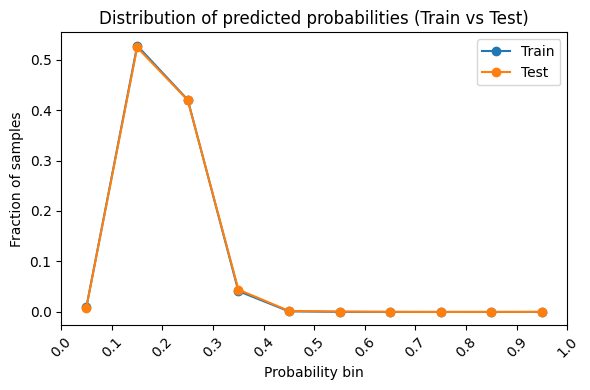

In [18]:
# PSI plot code
plt.figure(figsize=(6, 4))
x_mid = df_test_bins['bin'].apply(lambda x: x.mid).to_numpy()
plt.plot(x_mid, df_train_bins['fraction_train'].to_numpy(), label='Train', marker='o')
plt.plot(x_mid, df_test_bins['fraction_test'].to_numpy(), label='Test', marker='o')

plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.01, 0.1))  # ticks at 0.0, 0.1, 0.2, ..., 1.0
plt.xlabel("Probability bin")
plt.ylabel("Fraction of samples")
plt.title("Distribution of predicted probabilities (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

**Figure 3:** Plot confirming the small PSI value (the training curve is barely visible). The plot also shows that most predicted probabilities lie between 0 and 0.5, reflecting the class imbalance (80% non-defaults).

### Calibration

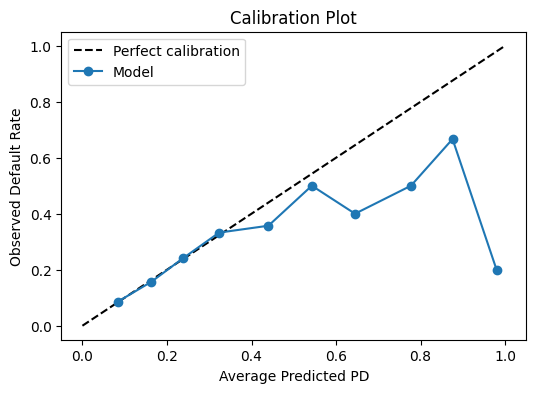

In [19]:
# Calibration plot code
df_calibration = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

n_bins_cali = 10
bin_edges = np.linspace(0, 1, n_bins_cali + 1)

df_calibration["bin"] = pd.cut(df_calibration['y_pred_proba'], bins=bin_edges, include_lowest=True)
calibration_table = df_calibration.groupby('bin', observed=False).agg(
    avg_pred=('y_pred_proba', 'mean'),          # Average predicted PD in the bin
    obs_default_rate=('y_test', 'mean'),        # Fraction of defaults in the bin
).reset_index() # make the bins a column instead of index, and use standard index

plt.figure(figsize=(6,4))
plt.plot([0,1], [0,1], 'k--', label='Perfect calibration')
plt.plot(calibration_table['avg_pred'].to_numpy(), calibration_table['obs_default_rate'].to_numpy(), marker='o', label='Model')
plt.xlabel('Average Predicted PD')
plt.ylabel('Observed Default Rate')
plt.title('Calibration Plot')
plt.legend()
plt.show()

**Figure 4:** The calibration plot shows how well predicted probabilities correspond to the actual fraction of defaulters. For example, if the average predicted probability in the bin [0, 0.1] is 0.06, the fraction of actual defaulters in that bin should also be approximately 0.06.

As we can see, the calibration starts failing at the exact same spot as where the distribution of predicted probabilities (plot above) approaches zero. One reason for this could be that since there are few samples at higher probabilities, the fractions get more sensitive to non-default outliers with high probability predictions, hence causing the model to overestimate probabilities in the upper range.

### Feature Importance

In [20]:
# feature importance code
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0].round(3)
}).sort_values('Coefficient', key=abs, ascending=False)

top_n_features = 5
feature_importance.head(top_n_features)


top_features = feature_importance.head(top_n_features)
top_features.style.hide(axis='index')

## Summary

The model's AUC of 0.605 suggests performance better than random, which indicates that the chosen variables do provide information about whether a loan will default or not. In particular, the five features in the feature importance table above are expected to provide useful infromation when predicting probability of default.

## Appendix: Full Python Code

```python
# Using Lending Club Loan Data,
# https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv

# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
import matplotlib.pyplot as plt

# Load sample dataset
df = pd.read_csv('loan_sample.csv', low_memory=False)

# Filter statuses
target_statuses = ['Fully Paid', 'Charged Off', 'Default']
df_filtered = df[df['loan_status'].isin(target_statuses)].copy()

# Encode target
df_filtered['default'] = df_filtered['loan_status'].isin(['Charged Off', 'Default']).astype(int)

# Class distribution code
counts = df_filtered['default'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values, color=['green','red'])
plt.ylabel('Number of Loans')
plt.xlabel('Class (0 = non-default, 1 = default)')
plt.title('Class Distribution')
plt.show() 

for cls in counts.index:
    print(f"Class {cls}: {counts[cls]} ({percent[cls]:.2f}%)")

# Variable selection code
selected_vars = [
    'annual_inc',
    'application_type',
    'dti',
    'home_ownership',
    'purpose',
    'default',  # target
    'issue_d',  # for time-based splitting
]
df_model = df_filtered[selected_vars].copy()

# Numeric variables description code
df_model.describe()

# Missing values code
missing_counts = df_model.isna().sum().sort_values(ascending=False)
missing_vars = missing_counts[missing_counts > 0]

total_rows = len(df_model)

if len(missing_vars) > 0:
    print("Variables with missing values:")
    for col, count in missing_vars.items():
        percentage = (count / total_rows) * 100
        print(f"{col}: {count} ({percentage:.2f}%)")
else:
    print("No missing values found")

# Replace missing values code
numeric_cols = df_model.select_dtypes(include=['number']).columns
df_model[numeric_cols] = df_model[numeric_cols].fillna(df_model[numeric_cols].median())

# One hot encoding code
categorical_cols = ['purpose', 'home_ownership', 'application_type']
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Time-based Train/test split
df_sorted = df_model.sort_values('issue_d')

split_point = int(0.8 * len(df_sorted))

X_train = df_sorted.iloc[:split_point].drop(['default', 'issue_d'], axis=1)
y_train = df_sorted.iloc[:split_point]['default']
X_test = df_sorted.iloc[split_point:].drop(['default', 'issue_d'], axis=1)
y_test = df_sorted.iloc[split_point:]['default']

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train model and make predictions
model = LogisticRegression() # L2 regularization by default
model.fit(X_train_scaled, y_train)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)


# Calculate recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

print(f"Class 0 recall: {recall_0:.2f}\n"
      f"Class 1 recall: {recall_1:.2f}")


# AUC and Gini
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC: {auc:.3f}")

gini = 2 * auc - 1
print(f"Gini coefficient: {gini:.3f}")


# ROC plot
plt.figure(figsize=(6,4))
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f})')

# plot KS point
ks_index = (tpr - fpr).argmax()
plt.scatter(fpr[ks_index], tpr[ks_index], color='red', s=30, label='KS point', zorder=5)

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# KS point
ks = max(tpr - fpr)
print(f'KS: {ks:.3f}')


# PSI code details
# Predicted probabilities for the training set
y_pred_proba_train = model.predict_proba(X_train_scaled)[:, 1]

n_bins = 10
bin_edges = np.linspace(0, 1, n_bins + 1)

df_PSI_test = pd.DataFrame({'y_pred_proba': y_pred_proba})

df_PSI_test['bin'] = pd.cut(df_PSI_test['y_pred_proba'], bins=bin_edges, include_lowest=True)

df_test_bins = (
    df_PSI_test.groupby('bin')
    .agg(count=('y_pred_proba', 'count'))
    .reset_index()
)

df_test_bins['fraction_test'] = df_test_bins['count'] / df_test_bins['count'].sum()

df_PSI_train = pd.DataFrame({'y_pred_proba_train': y_pred_proba_train})

df_PSI_train['bin'] = pd.cut(df_PSI_train['y_pred_proba_train'], bins=bin_edges, include_lowest=True)

df_train_bins = (
    df_PSI_train.groupby('bin')
    .agg(count=('y_pred_proba_train', 'count'))
    .reset_index()
)

df_train_bins['fraction_train'] = df_train_bins['count'] / df_train_bins['count'].sum()

def calculate_psi(train_frac, test_frac):
    """
    train_frac: array of fractions per bin in the baseline population
    test_frac: array of fractions per bin in the new population
    """
    epsilon = 1e-8  # to avoid division by zero
    psi_values = (train_frac - test_frac) * np.log((train_frac + epsilon) / (test_frac + epsilon))
    return np.sum(psi_values)

psi = calculate_psi(df_train_bins['fraction_train'], df_test_bins['fraction_test'])
print(f'PSI ({n_bins} bins): {psi:.3f}')


# PSI plot code
plt.figure(figsize=(6,4))
x_mid = df_test_bins['bin'].apply(lambda x: x.mid).to_numpy()
plt.plot(x_mid, df_train_bins['fraction_train'].to_numpy(), label='Train', marker='o')
plt.plot(x_mid, df_test_bins['fraction_test'].to_numpy(), label='Test', marker='o')

plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.01, 0.1))  # ticks at 0.0, 0.1, 0.2, ..., 1.0
plt.xlabel("Probability bin")
plt.ylabel("Fraction of samples")
plt.title("Distribution of predicted probabilities (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Calibration plot code
df_calibration = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

n_bins_cali = 10
bin_edges = np.linspace(0, 1, n_bins_cali + 1)

df_calibration["bin"] = pd.cut(df_calibration['y_pred_proba'], bins=bin_edges, include_lowest=True)
calibration_table = df_calibration.groupby('bin').agg(
    avg_pred=('y_pred_proba', 'mean'),          # Average predicted PD in the bin
    obs_default_rate=('y_test', 'mean'),        # Fraction of defaults in the bin
).reset_index() # make the bins a column instead of index, and use standard index

plt.figure(figsize=(6,4))
plt.plot([0,1], [0,1], 'k--', label='Perfect calibration')
plt.plot(calibration_table['avg_pred'].to_numpy(), calibration_table['obs_default_rate'].to_numpy(), marker='o', label='Model')
plt.xlabel('Average Predicted PD')
plt.ylabel('Observed Default Rate')
plt.title('Calibration Plot')
plt.legend()
plt.show()

# feature importance code
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0].round(3)
}).sort_values('Coefficient', key=abs, ascending=False)
top_n_features = 5
feature_importance.head(top_n_features)

top_features = feature_importance.head(top_n_features)
top_features.style.hide(axis='index')
